In [305]:
import os
os.getcwd()
os.chdir('/Users/utente/downloads')

In [307]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Data Preparation

In [312]:
import zipfile

# Unzipping the file
with zipfile.ZipFile('bank+marketing.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
# Load the data
data = pd.read_csv('bankfull.csv', sep=';')

data.columns = data.columns.str.lower().str.replace(' ', '_')
#categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)
data.y = (data.y == 'yes').astype(int)

In [313]:
df = data[['age', 'job', 'marital', 'education', 'balance', 'housing','contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']]

In [316]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1

In [319]:
from sklearn.metrics import roc_auc_score

df1 = df_train[['balance', 'day', 'duration', 'previous']]

# Loop through each variable
for var in df1:
    # Calculate AUC for the current variable
    auc_score = roc_auc_score(y_train, df1[var])
    print(f"AUC for {var}: {auc_score:.2f}")
    
    # Check if AUC is less than 0.5, meaning a negative correlation
    if auc_score < 0.5:
        print(f"{var} is negatively correlated, negating the values...")
        # Negate the variable to reverse the correlation
        neg_auc_score = roc_auc_score(y_train, -df1[var])
        print(f"AUC for negated {var}: {neg_auc_score:.2f}")


AUC for balance: 0.59
AUC for day: 0.47
day is negatively correlated, negating the values...
AUC for negated day: 0.53
AUC for duration: 0.81
AUC for previous: 0.60


## Question 2

In [354]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job','marital','education','housing','contact','month',
       'previous', 'poutcome']

In [356]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical ].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

/var/folders/20/x07dxm895ml9h7v683p6b0mw0000gn/T/ipykernel_14195/421721701.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  train_dict = df_train[numerical + categorical ].to_dict(orient='records')


LogisticRegression(max_iter=1000, solver='liblinear')

In [358]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
y_decision = (y_pred >= 0.5)
(y_val == y_decision).mean()

/var/folders/20/x07dxm895ml9h7v683p6b0mw0000gn/T/ipykernel_14195/2066633912.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  val_dict = df_val[numerical + categorical].to_dict(orient='records')


0.9033596018249689

In [360]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.3f}")


AUC: 0.912


## Question 3

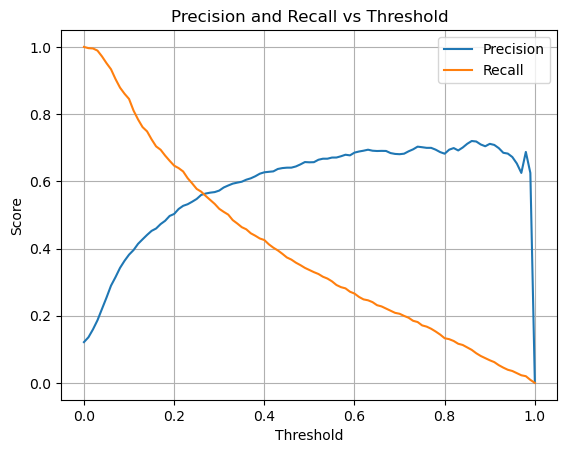

Precision and recall intersect at threshold: 0.26


In [338]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store precision and recall values
precisions = []
recalls = []

# Loop over each threshold and calculate precision and recall
for threshold in thresholds:
    y_pred_threshold = (y_pred >= threshold).astype(int)
    
  
    precision = precision_score(y_val, y_pred_threshold, zero_division=0)  # Set zero_division to handle undefined precision
    recall = recall_score(y_val, y_pred_threshold)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall curves intersect
for i, (precision, recall) in enumerate(zip(precisions, recalls)):
    if np.isclose(precision, recall, atol=0.01): 
        intersection_threshold = thresholds[i]
        print(f"Precision and recall intersect at threshold: {intersection_threshold:.2f}")
        break


## Question 4

Maximum F1 score: 0.587 at threshold: 0.210


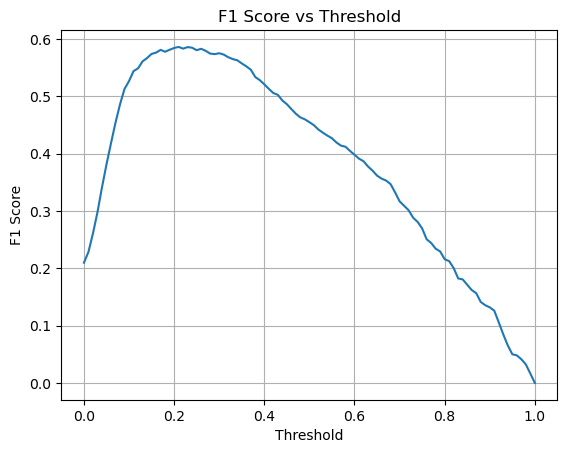

In [365]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store precision, recall, and F1 scores
precisions = []
recalls = []
f1_scores = []

# Loop over each threshold and calculate precision, recall, and F1 score
for threshold in thresholds:
    # Convert predicted probabilities into binary predictions based on the threshold
    y_pred_threshold = (y_pred >= threshold).astype(int)
    
    # Compute precision and recall for the current threshold
    precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    recall = recall_score(y_val, y_pred_threshold)
    
    # Compute F1 score using the formula
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the threshold where F1 score is maximum
max_f1 = max(f1_scores)
optimal_threshold = thresholds[f1_scores.index(max_f1)]

print(f"Maximum F1 score: {max_f1:.3f} at threshold: {optimal_threshold:.3f}")

# Plot F1 score vs Threshold
import matplotlib.pyplot as plt
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()


## Question 5

In [346]:
from tqdm.auto import tqdm


from sklearn.model_selection import KFold
import numpy as np

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
C = 1.0  

# Iterate over the K-Folds
for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=kfold.get_n_splits()):
    # Split the data into training and validation sets
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    # One-hot encode the features using DictVectorizer
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
    X_val = dv.transform(val_dict)

    # Train the Logistic Regression model
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate AUC score for validation set
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Output the mean and standard deviation of AUC scores
print(f'C={C} Mean AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}')


  0%|          | 0/5 [00:00<?, ?it/s]

C=1.0 Mean AUC: 0.906 +- 0.006


## Question 6

In [349]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

best_mean_auc = 0
best_std_auc = float('inf')
best_C = None

# Iterate over each value of C
for C in C_values:
    print(f"Evaluating C={C}")
    
    scores = []
    
    # Iterate over the K-Folds
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=kfold.get_n_splits()):
        # Split the data into training and validation sets
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        # One-hot encode the features using DictVectorizer
        dv = DictVectorizer(sparse=False)
        train_dict = df_train.drop('y', axis=1).to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val.drop('y', axis=1).to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # Train the Logistic Regression model with the current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities for validation set
        y_pred = model.predict_proba(X_val)[:, 1]

        # Calculate AUC score for validation set
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Compute the mean and standard deviation of AUC scores for the current C
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    print(f'C={C}: Mean AUC={mean_auc:.3f}, Std AUC={std_auc:.3f}')
    
    # Update the best C based on mean AUC, and then by std_auc in case of ties
    if (mean_auc > best_mean_auc) or (mean_auc == best_mean_auc and std_auc < best_std_auc):
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_C = C

# Print the best C value and its corresponding mean and std
print(f'Best C={best_C} with Mean AUC={best_mean_auc:.3f} and Std AUC={best_std_auc:.3f}')

Evaluating C=1e-06


  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06: Mean AUC=0.701, Std AUC=0.009
Evaluating C=0.001


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001: Mean AUC=0.861, Std AUC=0.007
Evaluating C=1


  0%|          | 0/5 [00:00<?, ?it/s]

C=1: Mean AUC=0.906, Std AUC=0.006
Best C=1 with Mean AUC=0.906 and Std AUC=0.006
